In [1]:
import utz
from utz import *
from utz.plots import symbols
from benchmarks.cli.data_loader import DEFAULT_DB_PATH, METHODS, TBL

[Papermill](https://papermill.readthedocs.io/en/latest/) parameters:

In [2]:
db_path = DEFAULT_DB_PATH    # SQL db path to read epoch stats from
tbl = TBL                    # SQL table name to read epoch stats from
out_dir = None               # Directory to save plot PNG/JSON to (e.g. "m3", "azl")
host = None                  # Description of host the stats were collected on, used in plot subtitle (e.g. "M3 Mac", "Amazon Linux")
show = None                  # Set to "png" to render plots in notebook as PNGs (good for noninteractive mode / Git-committing)
hostname_rgx = 'us-west-2'   # Filter DB "hostname" field to values matching this regex
host = "EC2 (g4dn.8xlarge)"  # Host display name (for plot subtitle)
since = '2024-06-07 11:00'   # Filter DB to "alb_start" >= this value
W = 1000                     # Output plot width
H =  600                     # Output plot height

In [3]:
# Parameters
out_dir = "azl"
show = "png"
host = "EC2 (g4dn.8xlarge)"
hostname_rgx = "us-west-2"
since = "2024-06-07 11:00"


In [4]:
db_uri = f'sqlite:///{db_path}'
df = pd.read_sql_table(tbl, db_uri)
if hostname_rgx:
    df = df[df.hostname.str.contains(hostname_rgx)].reset_index(drop=True).copy()
if since:
    since = to_dt(since)
    df = df[df.alb_start >= since].reset_index(drop=True).copy()
df

,start,epoch,n_rows,n_cols,elapsed,gc,max_mem,alb_start,sha,user,hostname,uri,method,batch_size,soma_chunk_size,shuffle_chunk_count,py_buffer_size,soma_buffer_size
0,2024-06-07 14:27:05.101534,0,132766,20000,12.261294,2.225195,18799632384,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824
1,2024-06-07 14:27:27.892621,1,132766,20000,12.497427,2.333607,17819193344,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824
2,2024-06-07 14:27:49.188758,2,132766,20000,12.533523,2.378042,17883447296,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824
3,2024-06-07 14:28:10.528086,3,132766,20000,11.627247,2.350551,16712495104,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824
4,2024-06-07 14:28:31.502126,4,132766,20000,12.417608,2.412700,17950883840,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-06-07 15:49:42.834216,0,132766,20000,16.228680,2.061194,4669157376,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824
116,2024-06-07 15:50:51.011554,1,132766,20000,16.532767,2.196312,4674187264,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824
117,2024-06-07 15:51:59.281386,2,132766,20000,16.730237,2.231337,4636938240,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824
118,2024-06-07 15:53:08.647740,3,132766,20000,16.755058,2.113498,4685479936,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824


In [5]:
hist = df[['hostname', 'method', 'shuffle_chunk_count', 'soma_chunk_size']].value_counts().sort_index().rename('num')
hist

hostname                                    method     shuffle_chunk_count  soma_chunk_size
ip-172-31-0-157.us-west-2.compute.internal  np.array   1                    131072             5
                                                       2                    65536              5
                                                       4                    32768              5
                                                       8                    16384              5
                                                       16                   8192               5
                                                       32                   4096               5
                                                       64                   2048               5
                                                       128                  1024               5
                                                       256                  512                5
                                   

In [6]:
pivoted = hist.reset_index(level=[0,1]).pivot(columns=['hostname', 'method'], values='num')
assert (pivoted == 5).all().all()
pivoted

hostname                            ip-172-31-0-157.us-west-2.compute.internal  \
method                                                                np.array   
shuffle_chunk_count soma_chunk_size                                              
1                   131072                                                   5   
2                   65536                                                    5   
4                   32768                                                    5   
8                   16384                                                    5   
16                  8192                                                     5   
32                  4096                                                     5   
64                  2048                                                     5   
128                 1024                                                     5   
256                 512                                                      5   
512                 256                                                      5   
1024                128                                                      5   
2048                64                                                       5   

hostname                                       
method                              scipy.csr  
shuffle_chunk_count soma_chunk_size            
1                   131072                  5  
2                   65536                   5  
4                   32768                   5  
8                   16384                   5  
16                  8192                    5  
32                  4096                    5  
64                  2048                    5  
128                 1024                    5  
256                 512                     5  
512                 256                     5  
1024                128                     5  
2048                64                      5

In [7]:
df['block_size'] = df.soma_chunk_size * df.shuffle_chunk_count
df['block_size_lg2'] = df['block_size'].apply(log2).astype(int)
block_lg2_vals = df['block_size_lg2'].unique().tolist()
block_lg2_vals.sort()
min_block_lg2, max_block_lg2 = min(block_lg2_vals), max(block_lg2_vals)
min_block_lg2, max_block_lg2, block_lg2_vals

(17, 17, [17])

In [8]:
df['chunk_lg2'] = df.soma_chunk_size.apply(log2)
chunk_lg2_vals = df.chunk_lg2.apply(int).unique().tolist()
chunk_lg2_vals.sort()
min_chunk_log2, max_chunk_log2 = min(chunk_lg2_vals), max(chunk_lg2_vals)
min_chunk_log2, max_chunk_log2, chunk_lg2_vals

(6, 17, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [9]:
df['count_lg2'] = df.shuffle_chunk_count.apply(log2).apply(int)
counts_lg2_vals = df.count_lg2.unique().tolist()
counts_lg2_vals.sort()
min_count_lg2, max_count_lg2 = min(counts_lg2_vals), max(counts_lg2_vals)
min_count_lg2, max_count_lg2, counts_lg2_vals

(0, 11, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [10]:
chunk_count_to_size = (
    df
    [['soma_chunk_size', 'shuffle_chunk_count']]
    .value_counts()
    .sort_index()
    .index
    .to_frame()
    .reset_index(drop=True, level=0)
    .soma_chunk_size
    .to_dict()
)
chunk_count_to_size

{2048: 64,
 1024: 128,
 512: 256,
 256: 512,
 128: 1024,
 64: 2048,
 32: 4096,
 16: 8192,
 8: 16384,
 4: 32768,
 2: 65536,
 1: 131072}

In [11]:
C = 'SOMA chunk size'
N = 'Shuffled chunk count'
S = 'Samples / sec'
df[C] = pd.Categorical(df.soma_chunk_size.apply(lambda c: f'{c:,}'))
df[N] = pd.Categorical(df.shuffle_chunk_count.apply(lambda c: f'{c:,}'))
chunk_sizes = df[C].unique()
shuffle_chunk_counts = df[N].unique()
df[S] = df.n_rows / df.elapsed
M = 'Max. memory usage'
df = df.rename(columns={ 'max_mem': M, 'method': 'Method', })
df

,start,epoch,n_rows,n_cols,elapsed,gc,Max. memory usage,alb_start,sha,user,hostname,uri,Method,batch_size,soma_chunk_size,shuffle_chunk_count,py_buffer_size,soma_buffer_size,block_size,block_size_lg2,chunk_lg2,count_lg2,SOMA chunk size,Shuffled chunk count,Samples / sec
0,2024-06-07 14:27:05.101534,0,132766,20000,12.261294,2.225195,18799632384,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824,131072,17,17.0,0,"131,072",1,10828.057677
1,2024-06-07 14:27:27.892621,1,132766,20000,12.497427,2.333607,17819193344,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824,131072,17,17.0,0,"131,072",1,10623.466543
2,2024-06-07 14:27:49.188758,2,132766,20000,12.533523,2.378042,17883447296,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824,131072,17,17.0,0,"131,072",1,10592.871946
3,2024-06-07 14:28:10.528086,3,132766,20000,11.627247,2.350551,16712495104,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824,131072,17,17.0,0,"131,072",1,11418.524467
4,2024-06-07 14:28:31.502126,4,132766,20000,12.417608,2.412700,17950883840,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,131072,1,1073741824,1073741824,131072,17,17.0,0,"131,072",1,10691.752764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-06-07 15:49:42.834216,0,132766,20000,16.228680,2.061194,4669157376,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824,131072,17,6.0,11,64,"2,048",8180.948842
116,2024-06-07 15:50:51.011554,1,132766,20000,16.532767,2.196312,4674187264,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824,131072,17,6.0,11,64,"2,048",8030.476777
117,2024-06-07 15:51:59.281386,2,132766,20000,16.730237,2.231337,4636938240,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824,131072,17,6.0,11,64,"2,048",7935.691410
118,2024-06-07 15:53:08.647740,3,132766,20000,16.755058,2.113498,4685479936,2024-06-07 14:27:04.965323,6f336356240e4d1a5e502f5f51584d043e6b61ff,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,64,2048,1073741824,1073741824,131072,17,6.0,11,64,"2,048",7923.935542


In [12]:
[hostname] = df.hostname.unique()
print(f'{hostname=}')
[batch_size] = df.batch_size.unique()
print(f'{batch_size=}')
[n_vars] = df.n_cols.unique()
print(f'{n_vars=}')

hostname='ip-172-31-0-157.us-west-2.compute.internal'
batch_size=1024
n_vars=20000


In [13]:
host_str = f"{host}, " if host else ""
host_subtitle = f'{host_str}{batch_size} samples per PyTorch batch'

In [14]:
def plot(
    fig,
    *args,
    **kwargs,
):
    return utz.plot(
        fig,
        *args,        
        dir=out_dir,
        w=W, h=H,
        **kwargs,
    )

In [15]:
title = "Samples/sec vs. memory use"

def ticktext(e):
    chunk_count = int(2**e)
    return f'{chunk_count:,}'

tickvals = counts_lg2_vals
colorbar = dict(
    title=utz.plots.title(['# Chunks', 'per shuffled block']),
    tickmode='array',
    tickvals=tickvals,
    ticktext=list(map(ticktext, tickvals)),
)

In [16]:
min_size, max_size = 9, 19
block_lg2_span = max_block_lg2 - min_block_lg2
if block_lg2_span == 0:
    df['marker_size'] = (min_size + max_size) / 2
else:
    df['marker_size'] = min_size + (max_size - min_size) * (df.block_size_lg2 - min_block_lg2) / block_lg2_span
size_vals = list(sorted(df.marker_size.unique()))
size_vals

[14.0]

In [17]:
marker2block_size = df[['block_size', 'marker_size']].drop_duplicates().set_index('marker_size').block_size.to_dict()
marker2block_size

{14.0: 131072}

In [18]:
min_opacity, max_opacity = 0.4, 0.9
epoch_vals = list(sorted(df.epoch.unique()))
min_epoch, max_epoch = epoch_vals[0], epoch_vals[-1]
df['marker_opacity'] = min_opacity + (max_opacity - min_opacity) * df.epoch / max_epoch
epoch2opacity = df[['epoch', 'marker_opacity']].drop_duplicates().set_index('epoch').marker_opacity.to_dict()
epoch_vals, epoch2opacity

([0, 1, 2, 3, 4], {0: 0.4, 1: 0.525, 2: 0.65, 3: 0.775, 4: 0.9})

Wrote plot JSON to azl/speed_vs_mem_1.png


Wrote plot image to azl/speed_vs_mem_1.png


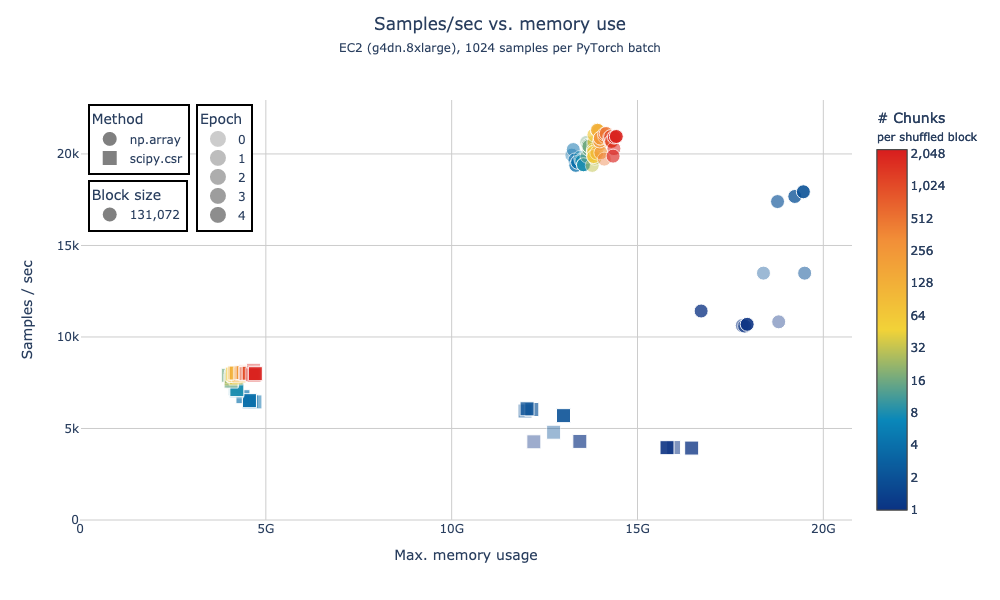

In [19]:
fig = go.Figure()

def dummy_trace(name, legend=None, **kwargs):
    marker = dict(color='gray')
    marker.update(kwargs)
    return go.Scatter(
        name=name,
        legend=legend,
        x=[None], y=[None], mode='markers',
        marker=marker,
    )

for idx, method in enumerate(METHODS):
    f = df[df.Method == method]
    symbol = symbols[idx]
    fig.add_trace(go.Scatter(
        name=method,
        x=f[M],
        y=f[S],
        mode='markers',
        marker=dict(
            color=f.count_lg2,
            colorscale=px.colors.diverging.Portland,
            cmin=min_count_lg2,
            cmax=max_count_lg2 + .12,
            colorbar=colorbar,
            showscale=True,
            opacity=f.marker_opacity,
            size=f.marker_size,
            symbol=symbol,
        ),
        customdata=f[['epoch', 'soma_chunk_size', 'shuffle_chunk_count', 'block_size',]],
        showlegend=False,
    ))

    # Dummy traces, for legend: one per fmt, set color/size (instead of inheriting from last data point in `f`)
    size = size_vals[-1]
    fig.add_trace(dummy_trace(
        method,
        size=size,
        symbol=symbol,
    ))

# Dummy legend/traces for `block_size` facet (represented by marker size)
for size in size_vals:
    block_size = marker2block_size[size]
    fig.add_trace(dummy_trace(
        f"{block_size:,}",
        legend="legend2",
        size=size,
        #symbol=symbols[0],
    ))

# Dummy legend/traces for `epoch` facet (represented by marker opacity)
#for epoch, opacity in [ (min_epoch, min_opacity), (max_epoch, max_opacity) ]:
for epoch, opacity in epoch2opacity.items():
    fig.add_trace(dummy_trace(
        f"{epoch}",
        legend="legend3",
        size=max_size,
        opacity=opacity,
    ))

def legend(title, **kwargs):
    defaults = dict(
        xanchor='left',
        yanchor='top',
        bordercolor="Black",
        borderwidth=2,
    )
    defaults.update(kwargs)
    return dict(
        title_text=title,
        **defaults
    )

plot(
    fig,
    utz.plots.title([
        title,
        host_subtitle,
    ], subtitle_size="0.7em"),
    title_y=.95,
    name="speed_vs_mem_1",
    hovertemplate=[
        "Epoch: %{customdata[0]}",
        "%s: %%{customdata[1]}" % C,
        "Chunks per shuffled block: %{customdata[2]}",
        "Shuffled block size: %{customdata[3]}",
        "Samples/sec: %{y:,d}",
        "Memory: %{x:.3s}",
    ],
    xtitle=M,
    xaxis_tickformat='s',
    xaxis_rangemode='tozero',
    ytitle=S,
    legend =legend('Method',     x=.01, y=.99, ),
    legend2=legend('Block size', x=.01, y=.81, ),
    legend3=legend('Epoch',      x=.15, y=.99, ),
    zerolines='y',
)